In [1]:
!pip install gymnasium

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Initialize the environment

In [4]:
env = gym.make("CartPole-v1") # render_mode = 'human'
state_space = env.observation_space.shape[0]
print('State Space:', state_space)
action_space = env.action_space.n
print('Action Space:', action_space)

State Space: 4
Action Space: 2


### Policy

In [5]:
# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [6]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon = 0.1
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 500

In [7]:
policy_net = DQN(state_space, action_space)
target_net = DQN(state_space, action_space)
# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()

In [8]:
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

In [9]:
# Function to choose action using epsilon-greedy policy
def select_action(state, epsilon):
    rand_value = random.random()
    if rand_value < epsilon:
        return env.action_space.sample()  # Explore
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()  # Exploit

# Function to optimize the model using experience replay
def optimize_model():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    done_batch = torch.FloatTensor(done_batch)

    # Compute Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Main training loop
rewards_per_episode = []
steps_done = 0

for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    count = 0

    # One episode (One Trajectory)
    while not done:
        if isinstance(state, tuple):
            state = state[0]

        if count > 499:
          break

        # Select action
        action = select_action(state, epsilon)
        next_state, reward, done, _ , _ = env.step(action)

        # Store transition in memory
        memory.append((state, action, reward, next_state, done))


        # Update state
        state = next_state
        episode_reward += reward

        # Optimize model
        optimize_model()

        # Update target network periodically
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        steps_done += 1

        count += 1

    # Decay epsilon
    print('Episode ',episode,': Reward = ',episode_reward)

    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    rewards_per_episode.append(episode_reward)


Episode  0 : Reward =  38.0
Episode  1 : Reward =  37.0
Episode  2 : Reward =  23.0
Episode  3 : Reward =  15.0
Episode  4 : Reward =  15.0
Episode  5 : Reward =  12.0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12412\2073889852.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  state_batch = torch.FloatTensor(state_batch)


Episode  6 : Reward =  8.0
Episode  7 : Reward =  10.0
Episode  8 : Reward =  12.0
Episode  9 : Reward =  9.0
Episode  10 : Reward =  10.0
Episode  11 : Reward =  12.0
Episode  12 : Reward =  11.0
Episode  13 : Reward =  10.0
Episode  14 : Reward =  8.0
Episode  15 : Reward =  10.0
Episode  16 : Reward =  10.0
Episode  17 : Reward =  9.0
Episode  18 : Reward =  10.0
Episode  19 : Reward =  10.0
Episode  20 : Reward =  9.0
Episode  21 : Reward =  10.0
Episode  22 : Reward =  11.0
Episode  23 : Reward =  10.0
Episode  24 : Reward =  8.0
Episode  25 : Reward =  11.0
Episode  26 : Reward =  9.0
Episode  27 : Reward =  11.0
Episode  28 : Reward =  12.0
Episode  29 : Reward =  10.0
Episode  30 : Reward =  9.0
Episode  31 : Reward =  10.0
Episode  32 : Reward =  10.0
Episode  33 : Reward =  10.0
Episode  34 : Reward =  9.0
Episode  35 : Reward =  8.0
Episode  36 : Reward =  10.0
Episode  37 : Reward =  10.0
Episode  38 : Reward =  12.0
Episode  39 : Reward =  10.0
Episode  40 : Reward =  9.0


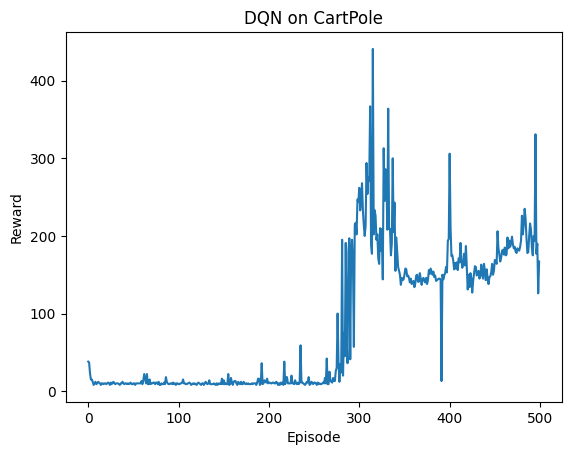

In [10]:
# Plotting the rewards per episode
import matplotlib.pyplot as plt
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN on CartPole')
plt.show()